In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.optimize import fmin_slsqp
from toolz import reduce, partial
import pyfixest as pf
from pyfixest import iplot

In [2]:
attainment = pd.read_excel("nayro.xls")
year_cols = [col for col in attainment.columns if col.startswith('yr')]

rb_codes = ["IL", "IN", "MI", "NY", "OH", "PA", "WV", "WI"]

attainment[year_cols] = attainment[year_cols].notna().astype(int)
attainment[attainment["st_abbr"].isin(rb_codes)]
#counties that have received non-attainment status
tr_counties_codes = attainment["fips_state"].astype(str) + attainment["fips_cnty"].astype(str)
tr_counties = tr_counties_codes.unique()


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


## Loading the Data

In [ ]:
def load_bea_data(file_path): 
    file = pd.read_csv(file_path)
    file["never_treated"] = (~file["GeoFIPS"].astype("string").isin(tr_counties)).astype(int)
    file = file[(file["GeoName"] == "Wayne, MI")|((file["never_treated"] == 1))]
    file["post"] = (file["year"] >= 2005).astype(int) # year in wich Wayne, MI was first assigned non-attainment status
    file["treated"] = (file["never_treated"] == 0).astype(int)
    file["D"] = file["post"] * file["treated"] # DID treatment indicator
    return file

gdp_tc = load_bea_data("gdp_components_rust_belt.csv") #GDP by county at industry level
income = load_bea_data("income_cleaned.csv") #personal income by county at industry level
output_index = load_bea_data("quant_index_cleaned.csv") #output quantity index by county at industry level

gdp_tc = gdp_tc.rename(columns={"All industry total": "gdp_all"})
gdp_tc["manufac_share"] = gdp_tc["Manufacturing"] / gdp_tc["gdp_all"]

In [42]:
# pre_treat avg up to 2004
gdp_pre03 = gdp_tc[gdp_tc["year"] <= 2004]
inc_pre03 = income[income["year"] <= 2004]

#avg share of manufacturing gdp and avg population in pre-treatment period
avg_share = (
    gdp_pre03
    .groupby("GeoFIPS")["manufac_share"]
    .mean()
)

avg_pop = (
    inc_pre03
    .groupby("GeoFIPS")["Population (persons) 2/"]
    .mean()
)

# cutoffs of a "manufacturing hub"
hub_share_cutoff = avg_share.quantile(0.5)
hub_pop_cutoff = 500000
share_cut_off_counties = avg_share[avg_share >= hub_share_cutoff].index
pop_cut_off_counties   = avg_pop[avg_pop >= hub_pop_cutoff].index

#apply to full panel 
hubs_gdp = gdp_tc[gdp_tc["GeoFIPS"].isin(share_cut_off_counties)&gdp_tc["GeoFIPS"].isin(pop_cut_off_counties)]

hubs_income = income[income["GeoFIPS"].isin(share_cut_off_counties)&income["GeoFIPS"].isin(pop_cut_off_counties)]

hubs_output = output_index[output_index["GeoFIPS"].isin(share_cut_off_counties)&output_index["GeoFIPS"].isin(pop_cut_off_counties)]

print(f"The analysis will focus on the following counties: {hubs_gdp['GeoName'].unique()}")

The analysis will focus on the following counties: ['Lake, IL' 'Marion, IN' 'Kent, MI' 'Macomb, MI' 'Wayne, MI' 'Monroe, NY'
 'Hamilton, OH' 'Montgomery, PA']


## Summary Statistics

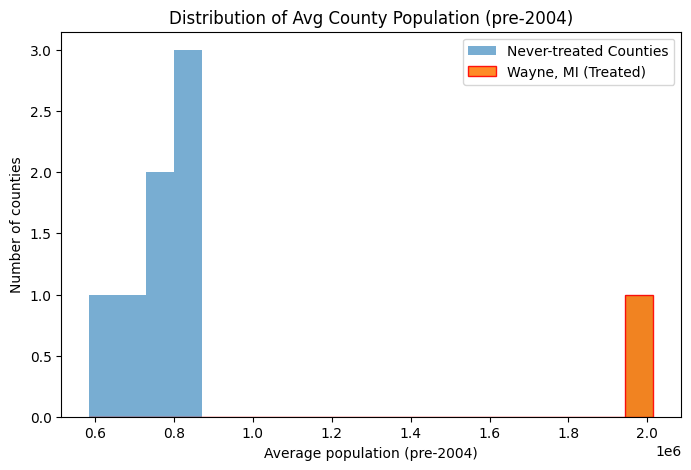

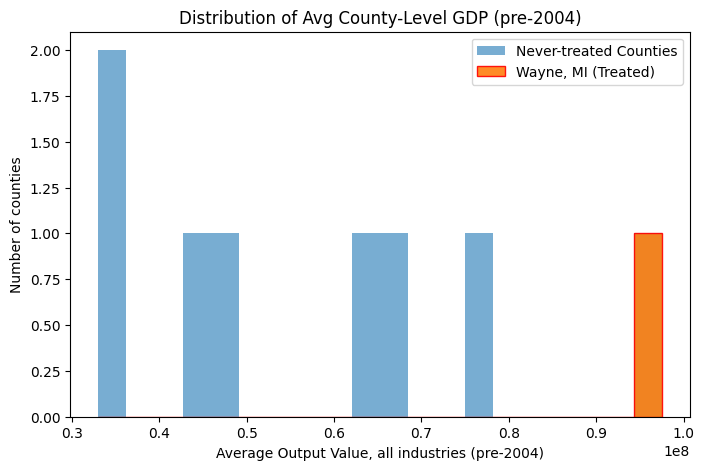

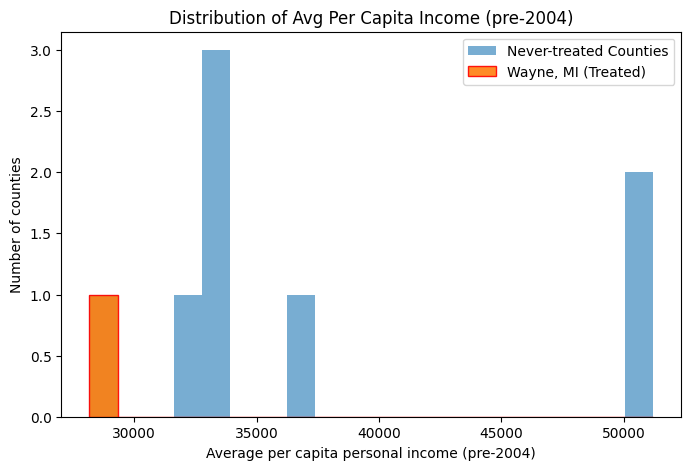

In [61]:

avg_income_pc = (
    hubs_income[hubs_income["year"] <= 2004]
    .groupby(["GeoFIPS", "treated"])["Per capita personal income (dollars)"]
    .mean()
)

avg_gdp_all = (
    hubs_gdp[hubs_gdp["year"] <= 2004]
    .groupby(["GeoFIPS", "treated"])["gdp_all"]
    .mean()
)

avg_pop = (
    hubs_income[hubs_income["year"] <= 2004]
    .groupby(["GeoFIPS", "treated"])["Population (persons) 2/"]
    .mean()
)

def hist_with_treated_highlight(series, value_col, xlabel, title, bins=20):
    df = series.reset_index()      
    vals = df[value_col]
    treated_vals = df.loc[df["treated"] == 1, value_col]

    bin_edges = np.histogram_bin_edges(vals, bins=bins)

    plt.figure(figsize=(8, 5))
    plt.hist(vals, bins=bin_edges, alpha=0.6, label="Never-treated Counties")
    plt.hist(
        treated_vals,
        bins=bin_edges,
        alpha=0.9,
        label="Wayne, MI (Treated)",
        edgecolor="red"     
    )
    plt.xlabel(xlabel)
    plt.ylabel("Number of counties")
    plt.title(title)
    plt.legend()


hist_with_treated_highlight(
    avg_pop,
    "Population (persons) 2/",
    "Average population (pre-2004)",
    "Distribution of Avg County Population (pre-2004)",
)

hist_with_treated_highlight(
    avg_gdp_all,
    "gdp_all",
    "Average Output Value, all industries (pre-2004)",
    "Distribution of Avg County-Level GDP (pre-2004)",
)

hist_with_treated_highlight(
    avg_income_pc,
    "Per capita personal income (dollars)",
    "Average per capita personal income (pre-2004)",
    "Distribution of Avg Per Capita Income (pre-2004)",
)



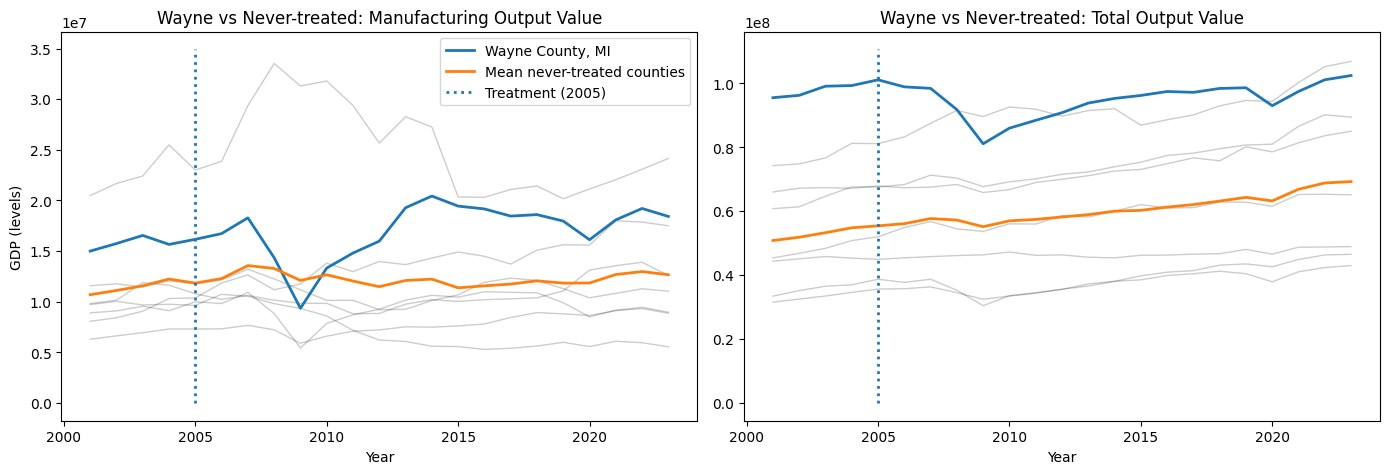

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for ax, col, title in zip(
    axes,
    ["Manufacturing", "gdp_all"],
    ["Manufacturing Output Value", "Total Output Value"],
):
    for _, gdf in hubs_gdp.groupby("GeoFIPS"):
        ax.plot(gdf["year"], gdf[col], alpha=0.2, lw=1, color="k")
    wayne = hubs_gdp[hubs_gdp["GeoName"] == "Wayne, MI"]
    ax.plot(
        wayne["year"],
        wayne[col],
        label="Wayne County, MI",
        lw=2,
    )
    (
        hubs_gdp[hubs_gdp["never_treated"] == 1]
        .groupby("year")[col]
        .mean()
        .plot(ax=ax, label="Mean never-treated counties", lw=2)
    )
    ymax = ax.get_ylim()[1]
    ax.vlines(
        x=2005,
        ymin=0,
        ymax=ymax,
        linestyle=":",
        lw=2,
        label="Treatment (2005)",
    )

    ax.set_title(f"Wayne vs Never-treated: {title}")
    ax.set_xlabel("Year")
axes[0].set_ylabel("GDP (levels)")
axes[1].set_ylabel("")

axes[0].legend()
plt.tight_layout()
plt.show()


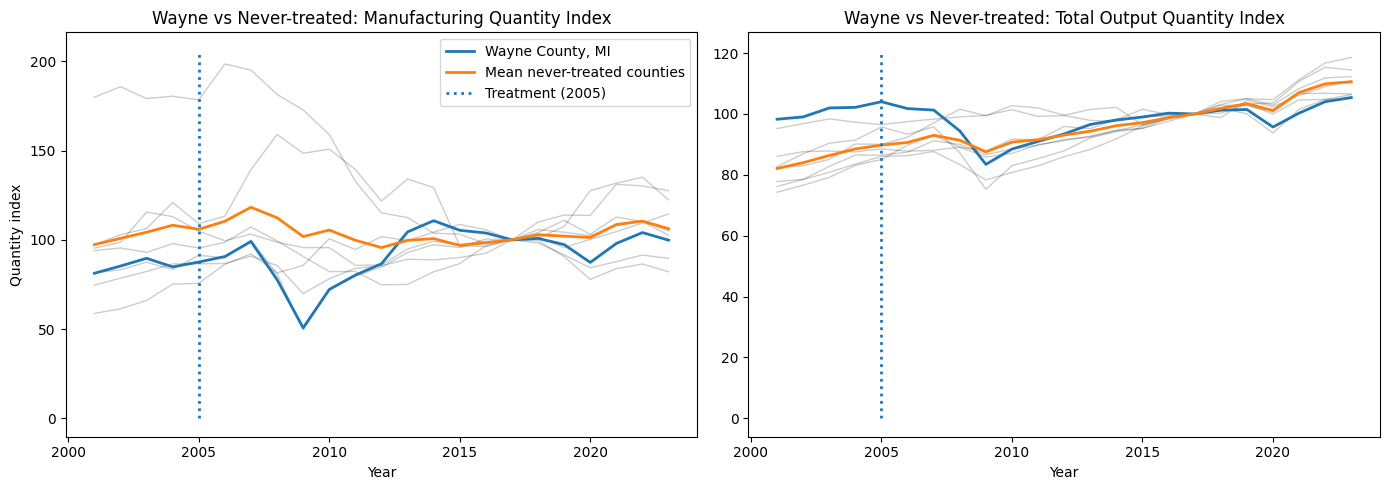

In [7]:
hubs_output = hubs_output.rename(columns={"All industry total": "gdp_all"})

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for ax, col, title in zip(
    axes,
    ["Manufacturing", "gdp_all"],
    ["Manufacturing Quantity Index", "Total Output Quantity Index"],
):

    for _, gdf in hubs_output.groupby("GeoFIPS"):
        ax.plot(gdf["year"], gdf[col], alpha=0.2, lw=1, color="k")

    wayne = hubs_output[hubs_output["GeoName"] == "Wayne, MI"]
    ax.plot(
        wayne["year"],
        wayne[col],
        label="Wayne County, MI",
        lw=2,
    )

    (
        hubs_output[hubs_output["never_treated"] == 1]
        .groupby("year")[col]
        .mean()
        .plot(ax=ax, label="Mean never-treated counties", lw=2)
    )

    ymax = ax.get_ylim()[1]
    ax.vlines(
        x=2005,
        ymin=0,
        ymax=ymax,
        linestyle=":",
        lw=2,
        label="Treatment (2005)",
    )

    ax.set_title(f"Wayne vs Never-treated: {title}")
    ax.set_xlabel("Year")

axes[0].set_ylabel("Quantity index")
axes[1].set_ylabel("")

axes[0].legend()
plt.tight_layout()
plt.show()


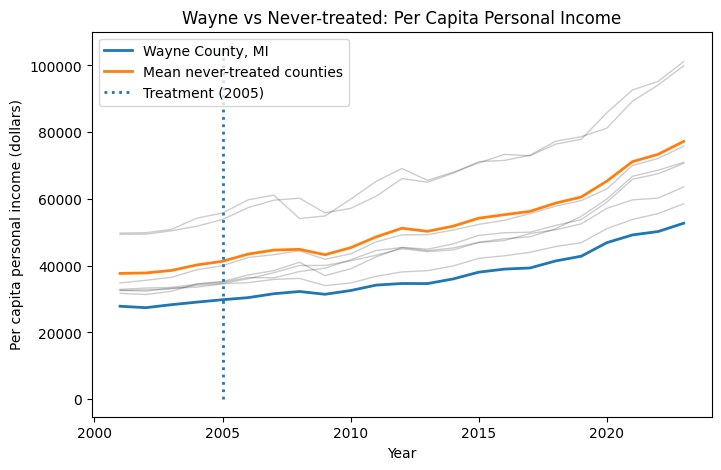

In [8]:
hubs_income = hubs_income.rename(
    columns={"Per capita personal income (dollars)": "pc_income"}
)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for _, gdf in hubs_income.groupby("GeoFIPS"):
    ax.plot(gdf["year"], gdf["pc_income"], alpha=0.2, lw=1, color="k")

wayne_inc = hubs_income[hubs_income["GeoName"] == "Wayne, MI"]
ax.plot(
    wayne_inc["year"],
    wayne_inc["pc_income"],
    label="Wayne County, MI",
    lw=2,
)

(
    hubs_income[hubs_income["never_treated"] == 1]
    .groupby("year")["pc_income"]
    .mean()
    .plot(ax=ax, label="Mean never-treated counties", lw=2)
)

ymax = ax.get_ylim()[1]
ax.vlines(
    x=2005,
    ymin=0,
    ymax=ymax,
    linestyle=":",
    lw=2,
    label="Treatment (2005)",
)

ax.set_ylabel("Per capita personal income (dollars)")
ax.set_xlabel("Year")
ax.set_title("Wayne vs Never-treated: Per Capita Personal Income")
ax.legend()



In [9]:
hubs_income["Manufacturing_pc"] = hubs_income["Manufacturing"]*1000/hubs_income["Population (persons) 2/"]

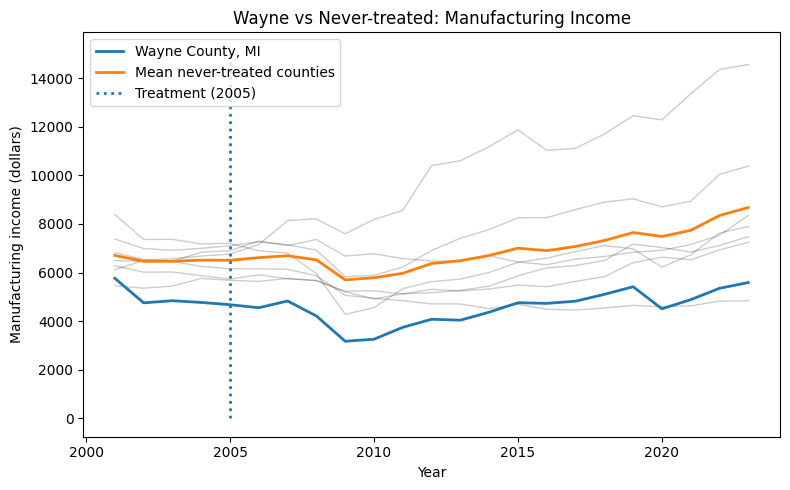

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for _, gdf in hubs_income.groupby("GeoFIPS"):
    ax.plot(gdf["year"], gdf["Manufacturing_pc"], alpha=0.2, lw=1, color="k")

wayne_inc = hubs_income[hubs_income["GeoName"] == "Wayne, MI"]
ax.plot(
    wayne_inc["year"],
    wayne_inc["Manufacturing_pc"],
    label="Wayne County, MI",
    lw=2,
)

(
    hubs_income[hubs_income["never_treated"] == 1]
    .groupby("year")["Manufacturing_pc"]
    .mean()
    .plot(ax=ax, label="Mean never-treated counties", lw=2)
)

ymax = ax.get_ylim()[1]
ax.vlines(
    x=2005,
    ymin=0,
    ymax=ymax,
    linestyle=":",
    lw=2,
    label="Treatment (2005)",
)

ax.set_ylabel("Manufacturing income (dollars)")
ax.set_xlabel("Year")
ax.set_title("Wayne vs Never-treated: Manufacturing Income")
ax.legend()
plt.tight_layout()
plt.show()


In [11]:
hubs_income

,GeoFIPS,GeoName,year,Apparel manufacturing,Beverage and tobacco product manufacturing,Chemical manufacturing,Computer and electronic product manufacturing,"Electrical equipment, appliance, and component manufacturing",Fabricated metal product manufacturing,Food manufacturing,...,Wages and salaries,Earnings by place of work,pc_income,Personal income (thousands of dollars),Population (persons) 2/,never_treated,post,treated,D,Manufacturing_pc
1104,17097,"Lake, IL",2001,-18.0,16827.0,1738932.0,384139.0,89676.0,282301.0,56109.0,...,15846975.0,21371509.0,49384.0,32543665.0,658986.0,1,0,0,0,6111.695848
1105,17097,"Lake, IL",2002,255.0,18337.0,1913030.0,374859.0,89098.0,274282.0,62819.0,...,16545495.0,22532731.0,49439.0,33026517.0,668022.0,1,0,0,0,6504.014838
1106,17097,"Lake, IL",2003,35.0,8378.0,1926668.0,375690.0,89258.0,297084.0,58388.0,...,16797844.0,22976556.0,50458.0,33744395.0,668760.0,1,0,0,0,6571.164543
1107,17097,"Lake, IL",2004,407.0,NaN,1995041.0,369661.0,87580.0,332972.0,56584.0,...,17513161.0,23748941.0,51830.0,35127244.0,677735.0,1,0,0,0,6677.062569
1108,17097,"Lake, IL",2005,1079.0,NaN,2039860.0,454155.0,94212.0,350765.0,61995.0,...,18342344.0,24625878.0,53846.0,36852917.0,684419.0,1,1,0,0,6758.890387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10874,42091,"Montgomery, PA",2019,45164.0,22918.0,2551106.0,397045.0,96753.0,416869.0,449115.0,...,40218967.0,48921586.0,77877.0,66328903.0,851716.0,1,1,0,0,6403.970338
10875,42091,"Montgomery, PA",2020,47000.0,29450.0,2728117.0,413102.0,116128.0,395495.0,440868.0,...,41566032.0,51491332.0,85842.0,73566532.0,856998.0,1,1,0,0,6634.003813
10876,42091,"Montgomery, PA",2021,45846.0,27841.0,2599968.0,398055.0,120516.0,405734.0,465175.0,...,45511905.0,57312243.0,92639.0,80063278.0,864249.0,1,1,0,0,6524.264419
10877,42091,"Montgomery, PA",2022,54876.0,34819.0,2857564.0,413081.0,117547.0,413628.0,513131.0,...,48927763.0,61333174.0,95237.0,82383972.0,865044.0,1,1,0,0,6930.113382


## TWFE Model

In [12]:
model_df = hubs_gdp[['Manufacturing', 'gdp_all', 'D', 'year', 'GeoFIPS', "treated"]].dropna().copy()
model_df['gdp_m'] = model_df['gdp_all'] / 1_000_000  
model_df['Manufacturing_m'] = model_df['Manufacturing'] / 1_000_000  

gdp_twfe = pf.feols(
    "gdp_m ~ i(year, treated,  ref = 2004) | GeoFIPS + year",
    model_df,
    vcov={"CRV1": "GeoFIPS"},
)

gdp_twfe.summary()



###

Estimation:  OLS
Dep. var.: gdp_m, Fixed effects: GeoFIPS+year
Inference:  CRV1
Observations:  184

| Coefficient                                       |   Estimate |   Std. Error |   t value |   Pr(>|t|) |    2.5% |   97.5% |
|:--------------------------------------------------|-----------:|-------------:|----------:|-----------:|--------:|--------:|
| C(year, contr.treatment(base=2004))[2001]:treated |      0.196 |        1.069 |     0.183 |      0.860 |  -2.331 |   2.723 |
| C(year, contr.treatment(base=2004))[2002]:treated |     -0.088 |        1.141 |    -0.077 |      0.940 |  -2.787 |   2.611 |
| C(year, contr.treatment(base=2004))[2003]:treated |      1.336 |        0.791 |     1.689 |      0.135 |  -0.534 |   3.207 |
| C(year, contr.treatment(base=2004))[2005]:treated |      1.192 |        0.336 |     3.544 |      0.009 |   0.397 |   1.988 |
| C(year, contr.treatment(base=2004))[2006]:treated |     -1.684 |        0.595 |    -2.831 |      0.025 |  -3.091 |  -0.278 |
| C(ye

In [13]:
manu_twfe = pf.feols(
    "Manufacturing_m ~ i(year, treated,  ref = 2004) | GeoFIPS + year",
    model_df,
    vcov={"CRV1": "GeoFIPS"},
)

manu_twfe.summary()

###

Estimation:  OLS
Dep. var.: Manufacturing_m, Fixed effects: GeoFIPS+year
Inference:  CRV1
Observations:  184

| Coefficient                                       |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| C(year, contr.treatment(base=2004))[2001]:treated |      0.885 |        0.744 |     1.190 |      0.273 | -0.874 |   2.645 |
| C(year, contr.treatment(base=2004))[2002]:treated |      1.213 |        0.608 |     1.996 |      0.086 | -0.224 |   2.650 |
| C(year, contr.treatment(base=2004))[2003]:treated |      1.553 |        0.516 |     3.007 |      0.020 |  0.332 |   2.774 |
| C(year, contr.treatment(base=2004))[2005]:treated |      0.904 |        0.452 |     1.999 |      0.086 | -0.165 |   1.973 |
| C(year, contr.treatment(base=2004))[2006]:treated |      1.023 |        0.506 |     2.022 |      0.083 | -0.174 |   2.219 |
| C

## Synthetic Control (Need fixes)

In [18]:
treat_year = 2005
features = ["gdp_all"]

inverted = (
    hubs_gdp.query("year < @treat_year")      
          .pivot(index="GeoName", columns="year")[features]  
          .T                               
)

inverted

GeoName       Hamilton, OH    Kent, MI    Lake, IL  Macomb, MI  Marion, IN  \
        year                                                                 
gdp_all 2001    65994999.0  31547592.0  45391974.0  33423302.0  74232291.0   
        2002    67176550.0  32504588.0  46809922.0  35138244.0  74775750.0   
        2003    67342175.0  33468689.0  48384651.0  36540874.0  76650095.0   
        2004    67131808.0  34592686.0  50798897.0  36959889.0  81198519.0   

GeoName       Monroe, NY  Montgomery, PA   Wayne, MI  
        year                                          
gdp_all 2001  44331667.0      60772818.0  95473905.0  
        2002  45090157.0      61352479.0  96211482.0  
        2003  45807122.0      64670246.0  99067192.0  
        2004  45310139.0      67596717.0  99262834.0

In [19]:
# treated unit = Wayne, MI
X1 = inverted["Wayne, MI"].values               

X0_names = [c for c in inverted.columns if c != "Wayne, MI"]
X0 = inverted[X0_names].values              


def loss_w(W, X0, X1) -> float:
    return np.sqrt(np.mean((X1 - X0.dot(W))**2))


def get_w(X0, X1):
    w_start = [1 / X0.shape[1]] * X0.shape[1]   
    weights = fmin_slsqp(
        partial(loss_w, X0=X0, X1=X1),
        np.array(w_start),
        f_eqcons=lambda x: np.sum(x) - 1,      
        bounds=[(0.0, 1.0)] * len(w_start),    
        disp=False
    )
    return weights

wayne_weights = get_w(X0, X1)


wayne_weights_series = pd.Series(wayne_weights, index=X0_names, name="weight")
print(wayne_weights_series.sort_values(ascending=False))


Monroe, NY        0.547757
Hamilton, OH      0.369388
Lake, IL          0.252988
Macomb, MI        0.252988
Kent, MI          0.252534
Marion, IN        0.149124
Montgomery, PA    0.076678
Name: weight, dtype: float64


In [20]:
X0_panel = (
    hubs_gdp.query('GeoName != "Wayne, MI"')
          .pivot(index="year", columns="GeoName")["Manufacturing"]
          .sort_index()
)

X0_panel = X0_panel[X0_names]

wayne_synth = X0_panel.values.dot(wayne_weights)

wayne_actual = (
    hubs_gdp[hubs_gdp["GeoName"] == "Wayne, MI"]
    .sort_values("year")
    .set_index("year")["Manufacturing"]
)

years = X0_panel.index  


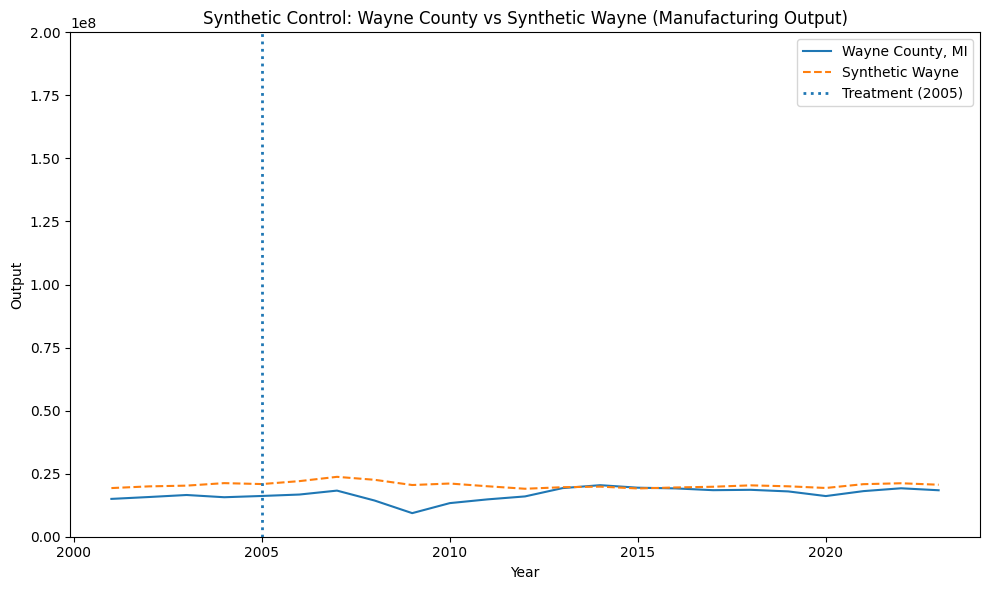

In [37]:
plt.figure(figsize=(10, 6))

plt.plot(wayne_actual.index, wayne_actual.values, label="Wayne County, MI")
plt.plot(years, wayne_synth, label="Synthetic Wayne", linestyle="--")

plt.vlines(x=2005, ymin=0, ymax=2e8, linestyle=":", lw=2, label="Treatment (2005)")
plt.ylim(0, 2e8)

plt.ylabel("Output")
plt.xlabel("Year")
plt.title("Synthetic Control: Wayne County vs Synthetic Wayne (Manufacturing Output)")
plt.legend()
plt.tight_layout()
plt.show()
